In [1]:
# 파일 확인 ( ls 명령어 사용 )

%%bash
ls -l drive/MyDrive/Colab\ Notebooks/data-files


total 831682
-rw------- 1 root root     30286 May 22  2023 auto-mpg.data
-rw------- 1 root root     32149 May 22  2023 auto-mpg.data-original
-rw------- 1 root root      1660 May 22  2023 auto-mpg.names
-rw------- 1 root root 851576689 Dec 11 02:57 dogs-vs-cats.zip
-rw------- 1 root root       161 May 22  2023 Index


In [2]:
# 파일 복사 ( gooogle driver -> sample_date)

%%bash
cp drive/MyDrive/Colab\ Notebooks/data-files/dogs-vs-cats.zip sample_data/

In [3]:
# 압축 풀기

%%bash
mkdir sample_data/dogs-vs-cats
unzip sample_data/dogs-vs-cats.zip -d sample_data/dogs-vs-cats

Archive:  sample_data/dogs-vs-cats.zip
  inflating: sample_data/dogs-vs-cats/sampleSubmission.csv  
  inflating: sample_data/dogs-vs-cats/test1.zip  
  inflating: sample_data/dogs-vs-cats/train.zip  


In [4]:
# 압축 풀기 2 (하위 폴더의 train.zip, test1.zip 파일 압축 해제)

%%bash
unzip sample_data/dogs-vs-cats/train.zip -d sample_data/dogs-vs-cats
unzip sample_data/dogs-vs-cats/test1.zip -d sample_data/dogs-vs-cats



Output hidden; open in https://colab.research.google.com to view.

In [5]:
# 폴더명 변경

%%bash
mv sample_data/dogs-vs-cats/test1 sample_data/dogs-vs-cats/test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras

In [8]:
# 데이터 딕렉토리 구성
# train_dir, test_dir, validation_dir # 훈련, 테스트, 검증 세트 폴드
# train_dir =:cats, dogs # 범주로 사용될 폴더
# test_dir -> cats, doogs
# validation_dir -> cats, dogs

import os, shutil

src_base = 'sample_data/dogs-vs-cats'
dest_base = 'sample_data/dogs-vs-cats2'

if os.path.exists(dest_base):  # 이미 존재하는 폴더라면
  shutil.rmtree(dest_base)     # 폴더 제거 후
os.mkdir(dest_base)            # 새로 폴더 만들기

# train 폴더의 0 ~ 1000 : trainset, 1000 ~ 1500 : validationset, 1500 ~ 2000 : testset
for start, stop, path in zip([0, 1000, 1500], [1000, 1500, 2000], ['train', 'validation', 'test']):
  os.mkdir(os.path.join(dest_base, path)) # train or validation or test 폴더 생성
  for sub_path in ['cat', 'dog']:
    os.mkdir(os.path.join(dest_base, path, sub_path)) # train, validation, test 하위에 cats or dog 폴더 생성
    for idx in np.arange(start, stop):
      fname = f'{sub_path}.{idx}.jpg'
      shutil.copy(os.path.join(src_base, 'train', fname), os.path.join(dest_base, path, sub_path, fname))

In [9]:
# 디렉토리 구성 결과 확인
for path in ['train', 'validation', 'test']:
  for subpath in ['cat', 'dog']:
    print(path, '/', subpath, ':', len(os.listdir(f'sample_data/dogs-vs-cats2/{path}/{subpath}')))

train / cat : 1000
train / dog : 1000
validation / cat : 500
validation / dog : 500
test / cat : 500
test / dog : 500


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras

In [11]:
# 입력 자동화 도구 만들기

# 특정 디렉터리의 파일을 읽어서 모델의 입력데이터로 변환하는 도구
train_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [12]:
# 입력 데이터 구성

datasets = []
for path, generator in zip(['train', 'test', 'validation'],
                [train_generator, test_generator, validation_generator]):
  dataset = generator.flow_from_directory(directory=f'sample_data/dogs-vs-cats2/{path}',
                                target_size=(256, 256),
                                batch_size=32,
                                class_mode='binary')
  datasets.append(dataset)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
print( type(datasets[0]) )
for X_batch, y_batch in datasets[0]:
  print(X_batch.shape, y_batch.shape)
  print(X_batch[0].max())
  print(y_batch)
  break

<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
(32, 256, 256, 3) (32,)
1.0
[1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 1.]


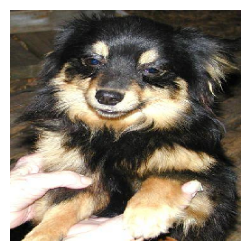

In [14]:
plt.figure(figsize=(3, 3))
plt.imshow(X_batch[2])
plt.axis('off')
plt.show()

In [20]:
# 모델 구조 설계

model = tf_keras.models.Sequential([
    tf_keras.layers.Input(shape=(256, 256, 3)),
    tf_keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    tf_keras.layers.MaxPooling2D((2, 2)),
    tf_keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    tf_keras.layers.MaxPooling2D((2, 2)),
    tf_keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    tf_keras.layers.MaxPooling2D((2, 2)),

    tf_keras.layers.Flatten(),

    tf_keras.layers.Dense(units=512, activation='relu', kernel_initializer='he_uniform'),
    tf_keras.layers.Dropout(rate=0.5),
    tf_keras.layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,203,137 (256.36 MB)

 Trainable params: 67,203,137 (256.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 모델 훈련 설계
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# 모델 훈련
fit_history = model.fit(datasets[0],
                        steps_per_epoch=60, epochs=20,
                        validation_data=datasets[2], validation_steps=30)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.5345 - loss: 9.3768 - val_accuracy: 0.6156 - val_loss: 0.6549
Epoch 2/20
 3/60 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.6125 - loss: 0.6690

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6481 - loss: 0.6446 - val_accuracy: 0.4500 - val_loss: 0.8101
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6480 - loss: 0.6158 - val_accuracy: 0.6135 - val_loss: 0.6647
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7180 - loss: 0.6533 - val_accuracy: 0.5750 - val_loss: 0.7194
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7346 - loss: 0.5285 - val_accuracy: 0.6333 - val_loss: 0.6493
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6872 - loss: 0.5680 - val_accuracy: 0.6250 - val_loss: 0.6723
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.7909 - loss: 0.4383 - val_accuracy: 0.6667 - val_loss: 0.7121
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027 - loss: 0.4684 - val_accuracy: 0.6750 - val_loss: 0.7099
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.8817 - loss: 0.2811 - val_accuracy: 0.6667 - val_loss

In [23]:
model.evaluate(datasets[0], steps=60), model.evaluate(datasets[1], steps=30)

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9964 - loss: 0.0131
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6419 - loss: 2.1851


([0.015506253577768803, 0.9963541626930237],
 [2.158149003982544, 0.6458333134651184])